### Building a Bridge: From Fires to People

The goals of this notebook are to:

1. determine the cumulative fraction of each basin that has burned
2. determine the fraction of each basin's upstream watershed that has burned
3. map those values to flood hazard zones
4. map enhanced flood hazards to census tracts
5. integrate enhanced flood hazard and social vulnerability to prioritize census tracts

#### Step 0: Step Up

In [1]:
# Import libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Address a Conda <--> PROJ error

In [2]:
# Source: https://gis.stackexchange.com/questions/364421/how-to-make-proj-work-via-anaconda-in-google-colab
import os; os.environ['PROJ_LIB'] = '/path/to/env/share/proj'

Import fire data, changing to a common coordiante system that supports measurement. Full credit to Matt for finding the fire data!

In [3]:
f=gpd.read_file("LAC_fires.geojson").to_crs(epsg=6933)

Check fire data by plotting it, color by year (just for fun), print image for presentation

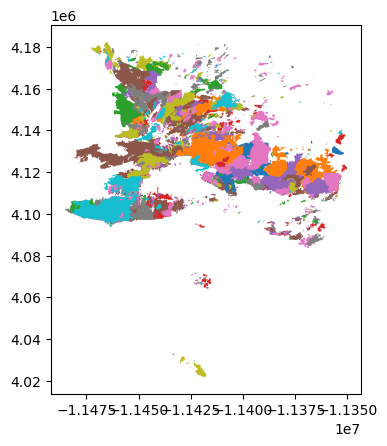

In [4]:
f.plot(column=f["YEAR_"])
plt.savefig("fires.png")

Next, import hydrologica basin data. This data set is too big to import and needs a bounding box:

In [5]:
bbox = (-118.9441,32.8065,-117.6447,34.8227)
# Source: https://observablehq.com/@rdmurphy/u-s-county-bounding-boxes-by-state

Now it can be imported, selected level 12 to get maximum spatial resolution

In [6]:
b=gpd.read_file("../week5/data/BasinATLAS_Data_v10.gdb.zip", driver='FileGDB', layer='BasinATLAS_v10_lev12',bbox=bbox)

As with fire data, change the coordinates to a common set

In [7]:
b=b.to_crs(6933)

Check basin data by plotting, color by max annual discharge, save image for presentation

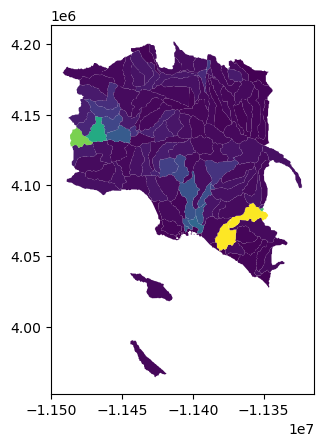

In [8]:
b.plot(column = b['dis_m3_pmx'])
plt.savefig("basins.png")

From my earlier basin exploration, I know I want to remove the two basins corresponding to islands:

In [9]:
b = b[b['HYBAS_ID']!=7120055730]
b = b[b['HYBAS_ID']!=7120055740]

Check that the islands were removed by plotting again, this time plotting by 2009 human footprint.

<AxesSubplot: >

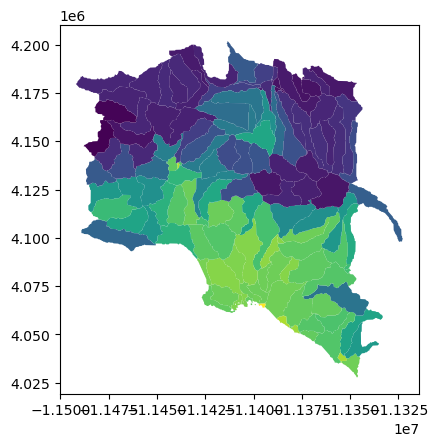

In [10]:
b.plot(column = b['hft_ix_s09'])

#### Step 1: Determine the cumulative fraction of each basin that has been burned

What I want to do now is use the `intersection` function in geopandas to find the area of each fire-to-basin overlap and sum those areas for each basin. For example, if a basin was 20% burned by one first and 15% burned by another, I want a number that scales with 35% -- regardless of whether or not the two fires themselves overlap (because, probably, they happened far enough apart... a more advanced version would add a recovery curve).

There is probably a better way to do this, but one method is to transform both geodataframes into lists with one basin (or fire) per list entry and then use "list comprehension" syntax to map the pairs through the intersection calculation.

Create a list "basins" with one entry per basin:

In [11]:
basins = []
for i in list(range(0,b.shape[0])):
    basins.append([b.iloc[i]])

Create a list "fires" with one entry per fire

In [12]:
fires = []
for i in list(range(0,f.shape[0])):
    fires.append([f.iloc[i]])

Here's just a check that these list items retain geometry:

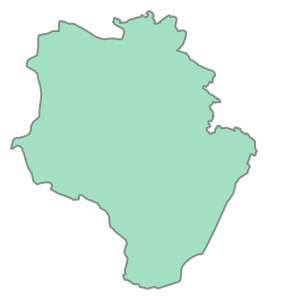

In [13]:
fires[0][0]["geometry"]

The next block is the heart of this section of code. These are three nested functions, that iterate through two lists of geographies, calculating the area of their intersection and summing them for each unit of one of the lists.

In [14]:
def f1(a,b):
    return a[0]["geometry"].intersection(b[0]["geometry"]).area
def f2(b,aa):
    return sum([f1(a,b) for a in aa])
def f3(aa,bb):
    return [f2(b,aa) for b in bb]

Now I can use this set of functions to compute the area of fire intersection in each basin:

In [15]:
burned=f3(fires,basins)

/opt/conda/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


Okay. `burned` should be a list with one entry per basin, with the entry being the cumulative burned area. Let's make sure there are the right number of entries.

In [16]:
print(len(burned))
print(len(basins))
print(b.shape[0])

133
133
133


Next, I want to assign each cumulative burned area to each basin, by creating a column in the geodataframe 'b' with values equal to the list 'burned'


In [17]:
b["burnt"] = burned

Check that this worked by plotting with color for cumulative burned fraction; save figure for presentation.

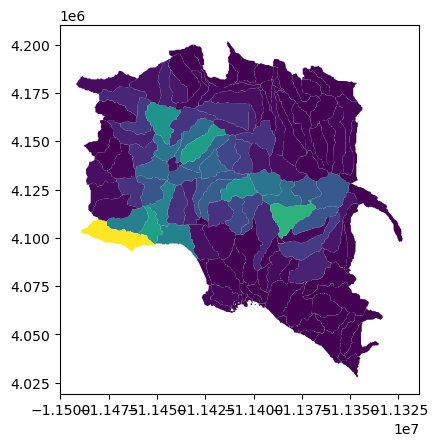

In [18]:
b.plot(column=b["burnt"])
plt.savefig("burnt.png")

Good -- the fires are in the hills!

### Step 2: Calculate for each basin the total burnt area in the basin and *upstream* of the basin.

The basin data already have a column providing the immediate *downstream* basin for each basin. For each basin, I need to identiy the immediate *upstream* basin(s).

First, let me make a list where the nth entry is the *downstream* basin for for basin n. To do this, I create a function to look up the downstream basin (working in the basins list, not the geodataframe.

In [19]:
def get_down(basin):
    return basin[0][1]

Now apply that function to all basins in the list, returning a list of downstream basins

In [20]:
downs = [get_down(basin) for basin in basins]

Now I need a function to look up the basin id (working in the basins list)

In [21]:
def get_id(basin):
    return basin[0][0]

And I will apply that function to all basins in the list; returning an ordered list of basin ids for using in a lookup.

In [22]:
ids = [get_id(basin) for basin in basins]

Now, I want to construct a square array where cell `[a,b]` is 1 if basin `b` drains into basin `a`, and otherwise is zero.

Step 2.1: make a square array with dimensoin matching the number of basins. Using the `identity` function in numpy, I can make this an identity matrix, which is a) square, b) has value zero everywhere except 1 on the diagonal. This is helpful because each basin flows into itself.

In [23]:
up = np.identity(len(basins))

Step 2.2: use the `downs` list to set to 1 any `[a,b]` where basin `b` flows into basin `a`.

In [24]:
for d in range(0,len(downs)):
    if downs[d]!=0:
        try:
            up[ids.index(downs[d])][d]=1
        except:
            1+1

Now we have a square matrix showing all immediate upstream connections

Step 2.3: Iterate through the matrix of immediate upstream connections to find basins upstream of upstream basins, basins upstream of basins upstream of upstream basins, etc

This will consist of a function and then nested for loops, with enough nesting to get through the network (see network diagram; I think 9 is sufficient, but I will use 10). Computationally, this is pretty inefficient, but Jupyter has enough power to do this with brute force...

In [25]:
def subit(z):
    return [i for i, x in enumerate(up[z]) if x == 1]

Now iterate back through the basin network, setting up[a,b]=1 any time b ultimately flows to a.

In [26]:
for i0 in range(0,len(basins)):
    x = list([i0])
    i1 = subit(i0)
    for z in i1:
        x.append(z)
        i2 = subit(z)
        for z in i2:
            x.append(z)
            i3 = subit(z)
            for z in i3:
                x.append(z)
                i4 = subit(z)
                for z in i4:
                    x.append(z)
                    i5 = subit(z)
                    for z in i5:
                        x.append(z)
                        i6 = subit(z)
                        for z in i6:
                            x.append(z)
                            i7 = subit(z)
                            for z in i7:
                                x.append(z)
                                i8 = subit(z)
                                for z in i8:
                                    x.append(z)
                                    i9 = subit(z)
                                    for z in i9:
                                        x.append(z)
                                        i10 = subit(z)
                                        for z in i10:
                                            x.append(z)
    up[i0][x]=1

Hopefull that worked. Let's check one:

In [27]:
up[40]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

This means that basin #40 receives water from #40, #41, #42, etc. Looks like this worked!

With the connection matrix, we now know which basins ultimately flow into which other basins. The next step is to sum the burnt area in each basin upstream of a given basin and return the total burned area upstream (including the basin itself).

Now I can calculate the total area burned upstream of the basin

In [28]:
def calc_burnup(i):
    return sum(np.multiply(up[i],burned))

Which I want to do for all basins...

In [29]:
burnup = [calc_burnup(i) for i in range(0,len(basins))]

This list `burnup` should be the upstream burned area for each basin. Let's put that information back into the geodataframe and plot things!

In [30]:
b["burnup"]=burnup

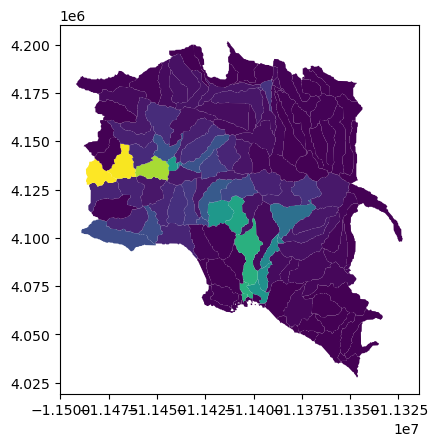

In [31]:
b.plot(column="burnup")
plt.savefig("burnup.png")

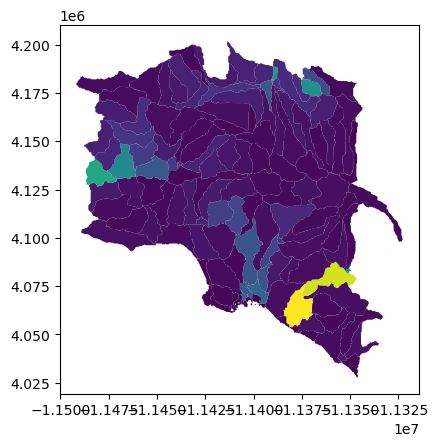

In [32]:
b.plot(column="UP_AREA")
plt.savefig("basins.png")

In [33]:
What fraction of the drainage has burned?

Type:        list
String form: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3978775.75941819 <...>  1929.4790453320425, 1114481.536151685, 12320300.234228019, 879210.1054172065, 8835682.846520571]
Length:      133
Docstring:  
Built-in mutable sequence.

If no argument is given, the constructor creates a new empty list.
The argument must be an iterable if specified.

In [34]:
b["fburnt"]=b["burnup"]/(b["UP_AREA"]*1000000)

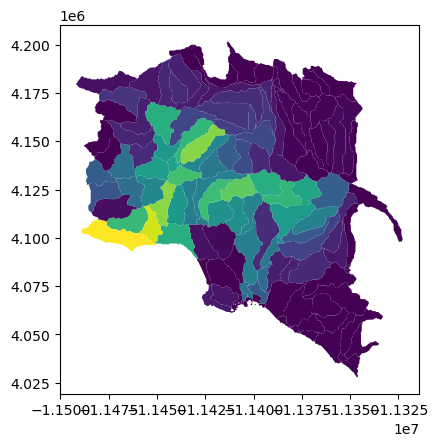

In [35]:
b.plot(column="fburnt")
plt.savefig("fburnt.png")

This map shows which basins are most vulnerable to fire-exacerbated discharge.

#### Step 3: Map fire-related discharge enchancement to current flood risk.

First, import the flood data (full credit to Hannah for finding and converting it to GeoJSON)

In [36]:
d = gpd.read_file('flood_r.geojson').to_crs(epsg=6933)

As above, I convert the dataframe to a list:

In [37]:
floods = []
for i in list(range(0,d.shape[0])):
    floods.append([d.iloc[i]])

Make a new list of "basins" so the entries include the calculations above

In [38]:
new_basins = []
for i in list(range(0,b.shape[0])):
    new_basins.append([b.iloc[i]])

As above, I need another triplet of functions. There are slightly different in that I want to multiply each area of intersection (flood risk zone * enhanced basin) by the fire-exacerbated discharge enhancement for that basin. Also, this time I will just divide by basin area to scale it directly, rather than as a separate step.

In [39]:
# New triplet of functions to aggregate intersections
def f4(a,b):
    return (a[0]["geometry"].intersection(b[0]["geometry"])).area
def f5(b,aa):
    return sum([f4(a,b)*a[0]["fburnt"] for a in aa])
def f6(aa,bb):
    return [f5(b,aa)/b[0]["geometry"].area for b in bb]

Apply these functions to the basins and flood risks; 

In [40]:
enhanced=f6(new_basins,floods)

/opt/conda/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


Assign the resulting values to the flood zone dataframe, plot it to check, and save the graphic for the presentation.

In [41]:
d["enhanced"]=enhanced

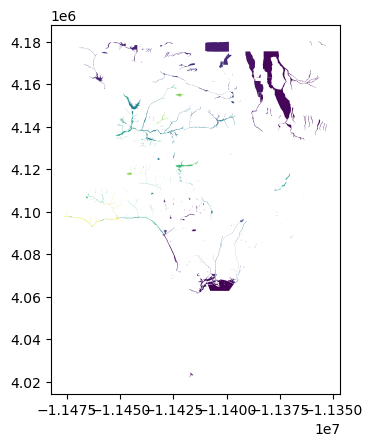

In [42]:
d.plot(column="enhanced")
plt.savefig("flood_enhance.png")

#### Step 4: Allocate enhanced flood risks to census tracts

Make a new list of "floods" so the entries include the calculations above

In [43]:
new_floods = []
for i in list(range(0,d.shape[0])):
    new_floods.append([d.iloc[i]])

Impact census tract data (I'm using CalEnviroScreen as a handy source); as above, use a bounding box (I found this with trial and error) and convert to the same coordinate system.

In [44]:
# Here is the data I will use:
data_file = '../week3/data/calenviroscreen40shpf2021shp.zip'
# Source: https://oehha.ca.gov/calenviroscreen/report/calenviroscreen-40
#bbox = (-119,32,-117,35)
bbox = (100000,-500000,225000,-350000)
c = gpd.read_file(data_file,bbox=bbox).to_crs(epsg=6933)

Filter for just tracts in LA County

In [45]:
c = c[c['County']=="Los Angeles"]

As above, create a list "tracts" with one entry per fire

In [46]:
tracts = []
for i in list(range(0,c.shape[0])):
    tracts.append([c.iloc[i]])

Check by plotting, color by 2019 population

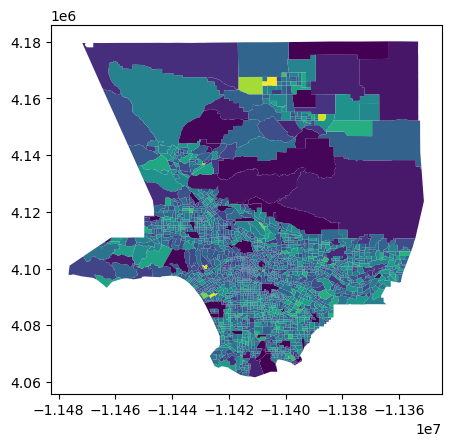

In [47]:
c.plot(column=c['TotPop19'])
plt.savefig("tracts.png")

Here comes the third set of triplet functions. This is very similar to the last, just pulling the "enhanced" value from the flood risk instead of burnt fraction from the basins.

In [48]:
def f7(a,b):
    return (a[0]["geometry"].intersection(b[0]["geometry"])).area
def f8(b,aa):
    return sum([f7(a,b)*a[0]["enhanced"] for a in aa])
def f9(aa,bb):
    return [f8(b,aa) for b in bb]

Apply this to the intersection of flood zones and census tracts (this step is slow! go get coffee!)

In [49]:
impact=f9(new_floods,tracts)

/opt/conda/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


As before, assing the outputs back to the geodataframe.

In [50]:
c["impact"]=impact

Find the area of each tract and standardize the `impact` values by area

In [51]:
areas = [tract[0]["geometry"].area for tract in tracts]

In [52]:
c["area"]=areas

In [53]:
c["scaled_impact"]=c["impact"]/c["area"]

Plot the data to check and also make the graphic for the presentation

<AxesSubplot: >

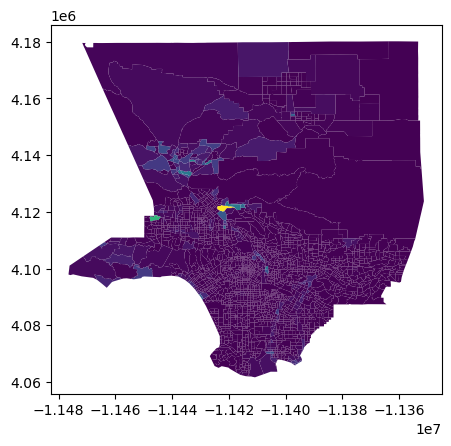

In [54]:
c.plot(column="scaled_impact")

These are the census tracts in LA County who flood risk is most sensitive to fire-exacerbation, prior to incorporating normal flood risk and population vulnerability.

#### Step 5: Integrate with social vulnerability scores

Here I am using CalEnviroScreen (already imported!); ultimate we will use a superior social vulnerability metric

First, drop tracts without scores, and plot for the presentation:

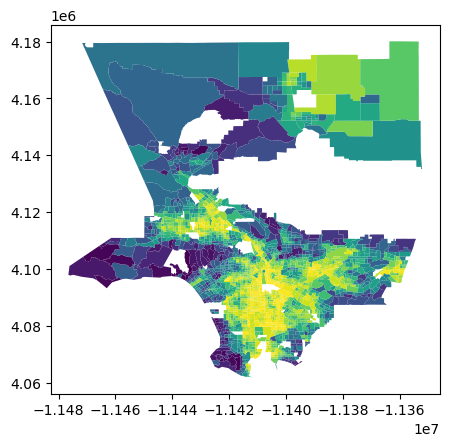

In [55]:
c[c["CIscoreP"]>0].plot(column="CIscoreP")
plt.savefig("ces.png")

Construct a column of scaled "fire enhanced flood" impact times CalEnviroScreen score

In [56]:
c["FEFxCES"]=c["scaled_impact"]*c["CIscoreP"]

Again drop tracts without scores and plot

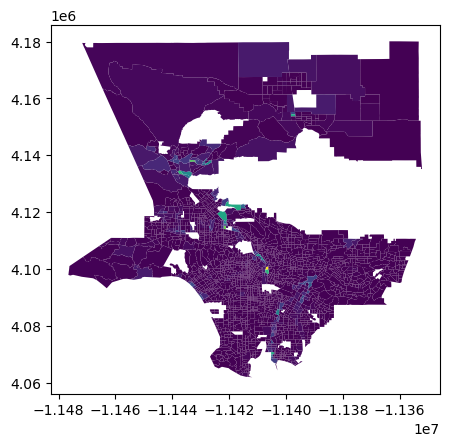

In [57]:
c[c["CIscoreP"]>0].plot(column="FEFxCES")
plt.savefig("fefxces.png")

Perhaps this tells us where to focus.

Still needed:
* proper social vulnerability indicators